In [1]:
library(rstanarm)
library(lme4)
library(ggplot2)
library(scales)
library(shinystan)
library(lubridate)
#library(parallel)

Sys.setenv("MC_CORES"= 1)
Sys.getenv("MC_CORES")
getOption("mc.cores", 1)



Warning message:
"package 'rstanarm' was built under R version 3.6.2"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 3.6.2"
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

rstanarm (Version 2.19.2, packaged: 2019-10-01 20:20:33 UTC)

- Do not expect the default priors to remain the same in future rstanarm versions.

Thus, R scripts should specify priors explicitly, even if they are just the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

options(mc.cores = parallel::detectCores())

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Warning message:
"package 'lme4' was built under R version 3.6.2"
Loading required package: Matrix

Warning message:
"package 'ggplot2' was built under R version 3.6.2"
Warning message:
"package 'scales' was built under R version 3.6.2"


[1] "1"

[1] 1

In [2]:
data = read.csv("data_co2_occ_num.csv")

colnames(data)[colnames(data) == 'sensor_name'] <- 'room'

summary(data)

                         X          occupancy          room     
 2019-11-20 07:00:00+00:00:   5   Min.   :0.0000   ROOM 1:1300  
 2019-11-20 07:15:00+00:00:   5   1st Qu.:0.0000   ROOM 2:1290  
 2019-11-20 07:30:00+00:00:   5   Median :0.0000   ROOM 3:1202  
 2019-11-20 07:45:00+00:00:   5   Mean   :0.3377   ROOM 4:1323  
 2019-11-20 08:00:00+00:00:   5   3rd Qu.:0.0000   ROOM 5:1334  
 2019-11-20 08:15:00+00:00:   5   Max.   :9.0000                
 (Other)                  :6419                                 
      co2             noise          humidity      temperature   
 Min.   : 400.0   Min.   :46.19   Min.   :30.76   Min.   :20.39  
 1st Qu.: 431.7   1st Qu.:48.63   1st Qu.:37.79   1st Qu.:21.31  
 Median : 469.0   Median :50.39   Median :40.24   Median :21.70  
 Mean   : 536.3   Mean   :51.79   Mean   :40.66   Mean   :21.80  
 3rd Qu.: 568.9   3rd Qu.:53.86   3rd Qu.:43.43   3rd Qu.:22.12  
 Max.   :2426.6   Max.   :73.30   Max.   :51.52   Max.   :24.77  
                  

Data rescaling and adding new categorical variables (to be used later)

In [3]:
data$co2.rescaled <- rescale(data$co2) 

data$log_co2 <- scale(log(data$co2))

data$room_category = unclass(data$room)

data$day_of_week <- factor(weekdays(as.Date(data$X)))

data$day_of_week_cat = unclass(data$day_of_the_week)

data$time<-format(strptime(data$X, "%Y-%m-%d %H:%M:%S"), "%H:%M:%S")

breaks <- hour(hm("00:00", "6:00", "12:00", "16:00", "23:59"))

labels <- c("Night", "Morning", "Afternoon", "Evening")

data$time_cat <- cut(x=hour(data$X), breaks = breaks, labels = labels, include.lowest=TRUE)

In [4]:
head(data)

,X,occupancy,room,co2,noise,humidity,temperature,co2.rescaled,log_co2,room_category,day_of_week,time,time_cat
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>",<int>,<fct>,<chr>,<fct>
1,2019-11-20 07:00:00+00:00,0,ROOM 1,471.7333,50.16000,36.28822,21.01033,0.03539532,-0.3413631,1,Wednesday,07:00:00,Morning
2,2019-11-20 07:15:00+00:00,0,ROOM 1,471.7333,51.08000,35.81867,21.06189,0.03539532,-0.3413631,1,Wednesday,07:15:00,Morning
3,2019-11-20 07:30:00+00:00,0,ROOM 1,471.7333,52.31598,35.66561,21.13359,0.03539532,-0.3413631,1,Wednesday,07:30:00,Morning
4,2019-11-20 07:45:00+00:00,0,ROOM 1,471.7333,50.47222,35.56245,21.21867,0.03539532,-0.3413631,1,Wednesday,07:45:00,Morning
5,2019-11-20 08:00:00+00:00,0,ROOM 1,480.8556,50.85000,35.45825,21.30693,0.03989649,-0.2672730,1,Wednesday,08:00:00,Morning
6,2019-11-20 08:15:00+00:00,0,ROOM 1,497.4042,50.83974,35.44168,21.39190,0.04806207,-0.1363842,1,Wednesday,08:15:00,Morning


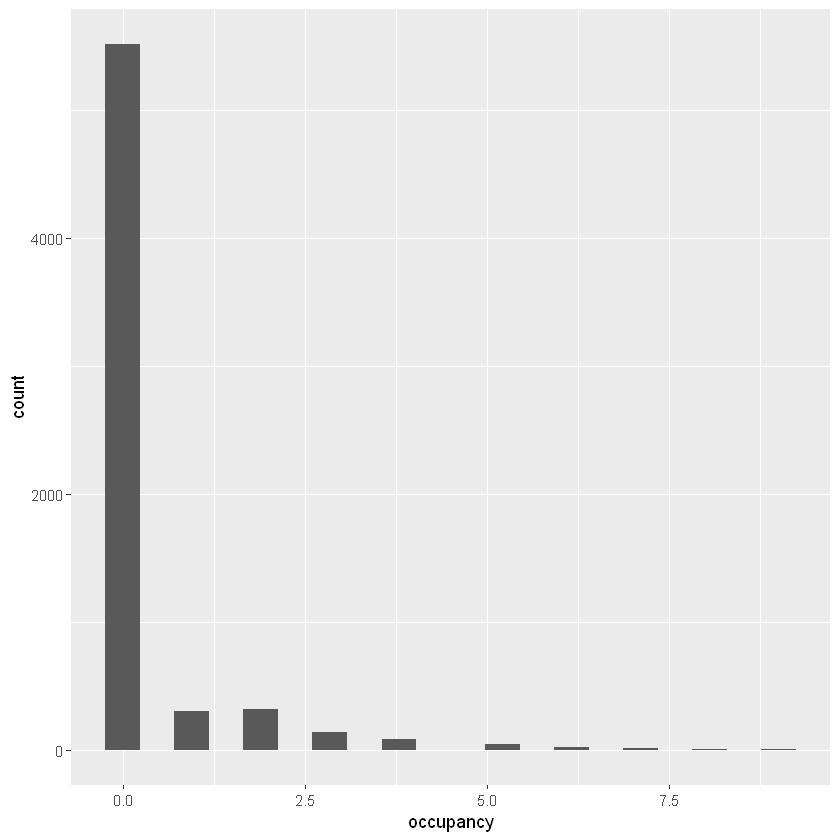

In [5]:
ggplot(data, aes(x = occupancy)) + geom_histogram(bins=20)

In [6]:
model2 <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room_category), data = data, family=poisson)

summary(model2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room_category)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  8170.1   8190.4  -4082.0   8164.1     6446 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1243 -0.4871 -0.4444 -0.3404  8.8062 

Random effects:
 Groups        Name        Variance Std.Dev.
 room_category (Intercept) 0.09844  0.3137  
Number of obs: 6449, groups:  room_category, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.9018     0.1437  -13.23   <2e-16 ***
co2.rescaled   6.2308     0.1044   59.69   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.149

# Hierarchical Model Equation

We introduce $i$ observations, $j$ groups

$\beta _{0j}$ and $\beta_{1j}$ are the intercept and slope (respectively) of the dependent variable in group $j$. Components $CO_2$ and $\epsilon_{ij}$ and predictor and error term, respectively.

First level:

$$ occupancy_{ij} = \beta_{0j} + \beta_{1j} \cdot CO_2 + \epsilon_{ij} $$

Second level:

$\gamma_{00}$ is the intercept and $\gamma_{10}$ is the slope, between the dependent variable and the Level 1 predictor. 
Components $u_{0j}$ and $u_{1j}$ are errors of intercept and slope.

Intercept:
$$\beta_{0j} = \gamma_{00} + u_{0j} $$

Slope:
$$ \beta_{1j} = \gamma_{10} + u_{1j} $$


In [ ]:
model2_stan <- stan_glmer(occupancy ~ 1 + co2.rescaled + (1 | room_category), 
                          data = data,
                          family=poisson,
                          adapt_delta = 0.99,
                          cores = 8,
                          iter = 2000,
                          seed = 12)

In [ ]:
summary(model2_stan)

In [ ]:
print(model2_stan, digits = 2)

In [ ]:
prior_summary(model2_stan)

In [ ]:
model2_posterior_prob <- posterior_interval(model2_stan,
                                            prob = 0.95)
round(model2_posterior_prob, 2)

In [ ]:
plot(model2_stan)

In [ ]:
plot(model2_stan, "rhat")
plot(model2_stan, "ess")

launch_shinystan(model2_stan)

## Graphical posterior predictive checks

In [ ]:
pp_check(model2_stan)

## Leave-one-out cross-validation 

In [ ]:
Sys.setenv("MC_CORES"= 1)

loo_model2 <- loo(model2_stan, k_threshold = 0.7)
loo_model2

In [ ]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(loo_model2, label_points = TRUE)

In [5]:
library(brms)
library(tidyverse)
library(ggthemes)
library(rstan)
library(StanHeaders)

Loading 'brms' package (version 2.11.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:lme4':

    ngrps


The following objects are masked from 'package:rstanarm':

    dirichlet, exponential, get_y, lasso, loo_R2, ngrps


Warning message:
"package 'tidyverse' was built under R version 3.6.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
v purrr   0.3.3     

Warning message:
"package 'tibble' was built under R version 3.6.2"
Warning message:
"package 'tidyr' was built under R version 3.6.2"
Warning message:
"package 'readr' was built under R version 3.6.2"
Warning message:
"package 'purrr' was built under R version 3.6.2"
Warning message:
"package 'dplyr' was built un

In [7]:
Sys.setenv("MC_CORES"= 1)

In [9]:
brm_model2 <- 
  brm(data = data, family = poisson,
      occupancy ~ 1 + co2.rescaled + (1 | room),
      iter = 2000, cores = 8,
      seed = 334, control = list(adapt_delta = 0.9999999), verbose=TRUE)

Compiling the C++ model

Warning message in system(cmd, intern = !verbose):
"running command 'C:/Users/mam/AppData/Local/Continuum/anaconda3/envs/r_based/lib/R/bin/x64/R CMD SHLIB file3a7418994686.cpp 2> file3a7418994686.cpp.err.txt' had status 1"


ERROR: Error in compileCode(f, code, language = language, verbose = verbose): Compilation ERROR, function(s)/method(s) not created! Warning message:
In system(cmd) : 'make' not found


ERROR: Error in sink(type = "output"): invalid connection


In [ ]:
stanplot(brm_model2)

In [ ]:
pairs(brm_model2)

In [ ]:
fitted(brm_model2) %>%
  as_tibble() %>%
  bind_cols(data)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey50", size = .5) +
  geom_point(size = 1.5, color = "firebrick4", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "firebrick4") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "firebrick4") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy") +
  theme_bw() +
  theme(panel.grid = element_blank())

In [ ]:
post_mdn <- 
  coef(b12.2, robust = T)$room[, , ] %>% 
  as_tibble() %>% 
  bind_cols(data) %>%
  mutate(post_mdn = inv_logit_scaled(Estimate))

post_mdn %>%
  ggplot(aes(x = room)) +
  geom_hline(yintercept = inv_logit_scaled(median(post$b_Intercept)), linetype = 2, size = 1/4) +
  geom_vline(xintercept = c(16.5, 32.5), size = 1/4) +
  geom_point(aes(y = propsurv), color = "orange2") +
  geom_point(aes(y = post_mdn), shape = 1) +
  coord_cartesian(ylim = c(0, 1)) +
  scale_x_continuous(breaks = c(1, 16, 32, 48)) +
  labs(title    = "Multilevel shrinkage!",
       subtitle = "The empirical proportions are in orange while the model-\nimplied proportions are the black circles. The dashed line is\nthe model-implied average survival proportion.") +
  annotate("text", x = c(8, 16 + 8, 32 + 8, 40 + 8, 48 + 8), y = 0, 
           label = c("Room 1", "Room 2", "Room 3", "Room 4", "Room 5")) +
  theme_fivethirtyeight() +
  theme(panel.grid = element_blank())
  